In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Arboles de decisión
## Arboles de regresión

Para practicar el modelo de arbol de regresión, vamos a usar el dataset **Hitters**, el cual contiene datos de jugadores de beisbol de la liga estadounidense de 1986 y 1987. Contiene 322 observaciones con 20 datos. Este conjunto de datos se tomó de la biblioteca StatLib que se mantiene en la Universidad Carnegie Mellon. Los datos salariales fueron originalmente de Sports Illustrated, 20 de abril de 1987. Las estadísticas de 1986 y de carrera se obtuvieron de The 1987 Baseball Encyclopedia Update publicado por Collier Books, Macmillan Publishing Company, Nueva York.

Lo que queremos hacer es tener alguna regresión de los salarios de 1987 los jugadores usando como base los datos de ellos de su perfomance en 1986.

In [44]:
# Cargamos el dataset
df_hitters = pd.read_csv("./Hitters.csv")

In [45]:
df_hitters.info()
#Vemos la información que tenemos, con las 20 columnas, donde una es el salario (la 19). 
# Hay un detalle en particular que no en todos tenemos el salario

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [46]:
df_hitters.describe()
#Podemos ver los valores mínimos y máximos para ver si están en la misma magnitud.


AtBat        Hits       HmRun        Runs         RBI       Walks  \
count  322.000000  322.000000  322.000000  322.000000  322.000000  322.000000   
mean   380.928571  101.024845   10.770186   50.909938   48.027950   38.742236   
std    153.404981   46.454741    8.709037   26.024095   26.166895   21.639327   
min     16.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
25%    255.250000   64.000000    4.000000   30.250000   28.000000   22.000000   
50%    379.500000   96.000000    8.000000   48.000000   44.000000   35.000000   
75%    512.000000  137.000000   16.000000   69.000000   64.750000   53.000000   
max    687.000000  238.000000   40.000000  130.000000  121.000000  105.000000   

            Years       CAtBat        CHits      CHmRun        CRuns  \
count  322.000000    322.00000   322.000000  322.000000   322.000000   
mean     7.444099   2648.68323   717.571429   69.490683   358.795031   
std      4.926087   2324.20587   654.472627   86.266061   334.105886   
min      1.000000     19.00000     4.000000    0.000000     1.000000   
25%      4.000000    816.75000   209.000000   14.000000   100.250000   
50%      6.000000   1928.00000   508.000000   37.500000   247.000000   
75%     11.000000   3924.25000  1059.250000   90.000000   526.250000   
max     24.000000  14053.00000  4256.000000  548.000000  2165.000000   

              CRBI       CWalks      PutOuts     Assists      Errors  \
count   322.000000   322.000000   322.000000  322.000000  322.000000   
mean    330.118012   260.239130   288.937888  106.913043    8.040373   
std     333.219617   267.058085   280.704614  136.854876    6.368359   
min       0.000000     0.000000     0.000000    0.000000    0.000000   
25%      88.750000    67.250000   109.250000    7.000000    3.000000   
50%     220.500000   170.500000   212.000000   39.500000    6.000000   
75%     426.250000   339.250000   325.000000  166.000000   11.000000   
max    1659.000000  1566.000000  1378.000000  492.000000   32.000000   

            Salary  
count   263.000000  
mean    535.925882  
std     451.118681  
min      67.500000  
25%     190.000000  
50%     425.000000  
75%     750.000000  
max    2460.000000

In [47]:
# Como los datos de salario no están completos, descartamos a aquellos jugadores que no tienen ese dato.
df_hitters.dropna(subset="Salary", inplace=True)
#Eliminamos los registros donde no tenemos los salarios

In [48]:
# Aplico feature engineering, modificando el target por el logaritmo
df_hitters["Salary_log"] = np.log(df_hitters["Salary"])
#Trabajamos con los logaritmos porque son muy pocos los jugaodres que tienen salarios muy altos
#En cambio el log del salario tiene menos dispersion de datos, es la mimsa informacion

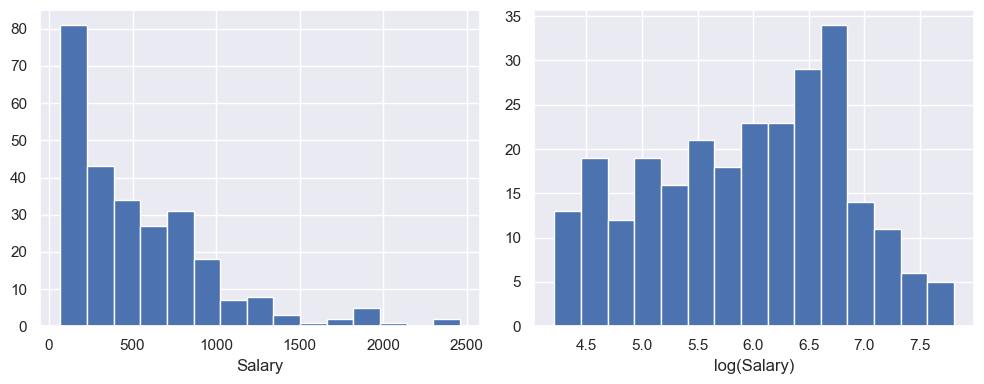

In [49]:
f, ax = plt.subplots(1,2, figsize=(10, 4))
df_hitters["Salary"].hist(ax=ax[0], bins=15)
df_hitters["Salary_log"].hist(ax=ax[1], bins=15)

ax[0].set_xlabel("Salary")
ax[1].set_xlabel("log(Salary)")
plt.tight_layout()

Como podemos ver, mejoramos la dispersion de datos, principalmente aquellos que estan en los primeros bins.

----

Trabajemos en el modelo

Empezamos separando los datos, para este ejemplo, solo voy a usar *Hits, Putouts, RBI, Runs, Walks y Years*. Que significa cada cosa está [explicado aqui](https://rdrr.io/cran/ISLR/man/Hitters.html)

In [50]:
# Para este ejemplo, solo voy a usar Years, RBI, PutOuts, Hits, Walks, Run como atributos. 
X = df_hitters.loc[:, ["Hits", "PutOuts", "RBI", "Runs", "Walks", "Years"]].values
# Y como variable a predecir a Salary_log
y = df_hitters.loc[:, "Salary_log"].values
#Vamos a separar los de entrada con los los de salida.

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 42)
#Se paramos el 40% para test

Ahora vamos a aplicar el procedimiento que vimos, primero llamamos al modelo de [arbol de regresion](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [53]:
from sklearn.tree import DecisionTreeRegressor
#Vamos a llamar a la librerio de árbol de regresión

In [54]:
# Creamos el arbol
regression = DecisionTreeRegressor(criterion='squared_error', splitter='best', 
                                   max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                   random_state=42)
# Y entrenamos
regression.fit(X_train, y_train)
#El criterio del residuo va a ser el error cuadrático. Vamos a encontar la mejor divsión,que bifurca las áreas
#El maximo nos dice la profundidad máxima
#Se le da el mínmo de 2
#Se le da el mínimo de la cantidad de muestras por hoja que es 1


DecisionTreeRegressor(random_state=42)

Podemos  ver cuales son los parametros de creacion de mi modelo (esto sale en la documentacion misma y es comun a todos los modelos) usando ".get_params()".

In [55]:
regression.get_params()
#Ve las características del modelo que se acaba de entrenar.
#El alpja por el castigo del crecieminto del árbol es cero.

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

Podemos ver a nuestro arbol para entender que hizo usando [export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html)

In [56]:
from sklearn.tree import export_graphviz
export_graphviz(regression, out_file = "arbol_regresion.dot",
                feature_names=["Hits", "PutOuts", "RBI", "Runs", "Walks", "Years"],
                rounded=True,
                filled=True)
#Es una herramienta que se llama export_graphviz que me permite graficar el árbol
#Lo va a guardar en arbol_regresion.dot.
#Si lo abrimos está toda la informacion del árbol, lo copiamos em ingresamos al link.
#Lo pegamos y me grafica todo el árbol.
#Podemos ver rápidamente la cantidad de muestra.
#Con una muestras está sobreajustadísimo.

Podemos ver nuestro arbol en [webgraphviz](http://www.webgraphviz.com/?tab=map). Esta pagina nos mostrara la disposicion de nuestros nodos y como el algoritmo fue tomando desicion de las diferentes divisiones.

Es por esto que prefiero usar la herramienta web, se puede trabajar, para mejorar la gráfica:

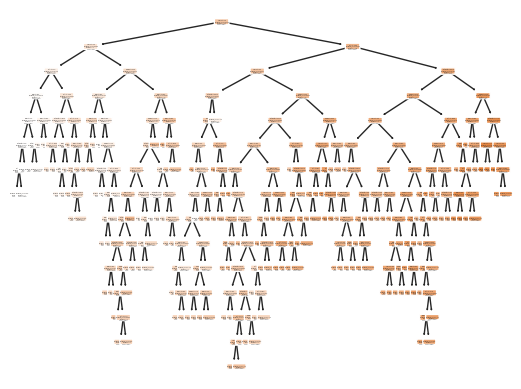

In [14]:
from sklearn.tree import plot_tree
plot_tree(regression, filled=True, feature_names=["Hits", "PutOuts", "RBI", "Runs", "Walks", "Years"], rounded=True);
#Se puede hacer con plot tree

Midamos como este modelo performa usando el error medio absoluto:

In [57]:
from sklearn.metrics import mean_absolute_error

y_pred_train = regression.predict(X_train)
y_pred = regression.predict(X_test)
#Hacemos las predicciones con train y con test

mae_train = mean_absolute_error(y_train, y_pred_train)
mae = mean_absolute_error(y_test, y_pred)
# A cada una le realizamos el error

print(f"El error de entreamiento fue: {mae_train}")
print(f"El error de testeo fue: {mae}")
#Con los de train es cero el error, pero con test es caso el 50%, está super ajsutado.

El error de entreamiento fue: 0.0
El error de testeo fue: 0.4601579497699184


Este resultado es muy malo, si el entrenamiento es cero, es seguro que hay overfitting (esto lo esperabamos, por elegimos que las hojas tengan una sola muestra). Pero comparemos con algun modelo, rapidamente para tener alguna referencia

In [2]:
from sklearn.linear_model import LinearRegression
regresion_lineal = LinearRegression()
regresion_lineal.fit(X_train, y_train)

y_pred_lineal = regresion_lineal.predict(X_test)

print(f"El error de testeo fue: {mean_absolute_error(y_test, y_pred_lineal)}")

#Nos da también un error grande de la relación lineal.

NameError: name 'X_train' is not defined

Asi y todo, performo mejor que el modelo de regresión lineal, pero no por mucho.

----

Ahora intentemos podar el arbol, para ello vamos a usar el argumento [ccp_alpha](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning) que es el alfa que vimos en clase para podar arboles y cross-validation para encontrar el mejor valor de alpha que logre podar el arbol pero minizar lo mas posible el error usando validación cruzada con 5 folds.

Ademas vamos a llamar a [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) que nos va a permitir calcular la metrica de evaluacion usando [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)

In [58]:
from sklearn.model_selection import cross_val_score
#Vamos a ponerle un alpha que sea más chico y que mejore la performance del modelo. 


In [61]:
# Hagamos una ejecucion de prueba
#Vamos a hacer un primer entrenamiento con alpha igual a cero y hacemos la validación cruzada

clf = DecisionTreeRegressor(criterion='squared_error', splitter='best', 
                            max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                            random_state=42, ccp_alpha=0)

scores = cross_val_score(clf, X_train, y_train, cv=5, 
                         scoring='neg_mean_absolute_error', n_jobs=-1)
#Le decimos que el cross validation va a ser de 5, dividiendo el conjunto en 5
scores = np.abs(scores)
print(f"El valor medio de MAE cuando alfa es cero: {np.mean(scores)}")
# Para cada iteración vamos a tener distintos errores. Obteniendo diferentes scores.

El valor medio de MAE cuando alfa es cero: 0.5446876946213496


Que interesante! El error de CV es cercano al del set de testeo

In [63]:
# Hagamos Cross-validation para varios valores de Alfa
scores_list = []
alpha_array = np.linspace(0, 0.5, 1000)
leaf_array = np.zeros_like(alpha_array)
for index, alpha in enumerate(alpha_array):
    clf = DecisionTreeRegressor(criterion='squared_error', splitter='best', 
                                max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                random_state=42, ccp_alpha=alpha)
    scores_list.append(np.abs(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')))
    #Hacemos la vlaidacion cruzada para cada alpha
    clf.fit(X_train, y_train)
    on_leaf = clf.apply(X_train)
    leaf_array[index] = len(np.unique(on_leaf))

scores_array = np.array(scores_list)
del scores_list

df_results = pd.DataFrame({"alpha": alpha_array,
                           "on_leaf": leaf_array,
                           "mae1": scores_array[:, 0],
                           "mae2": scores_array[:, 1],
                           "mae3": scores_array[:, 2],
                           "mae4": scores_array[:, 3],
                           "mae5": scores_array[:, 4]})
#Gurdamos para graficar

df_results = pd.melt(df_results, id_vars=['alpha', 'on_leaf'], value_vars=["mae1", "mae2", "mae3", "mae4", "mae5"])

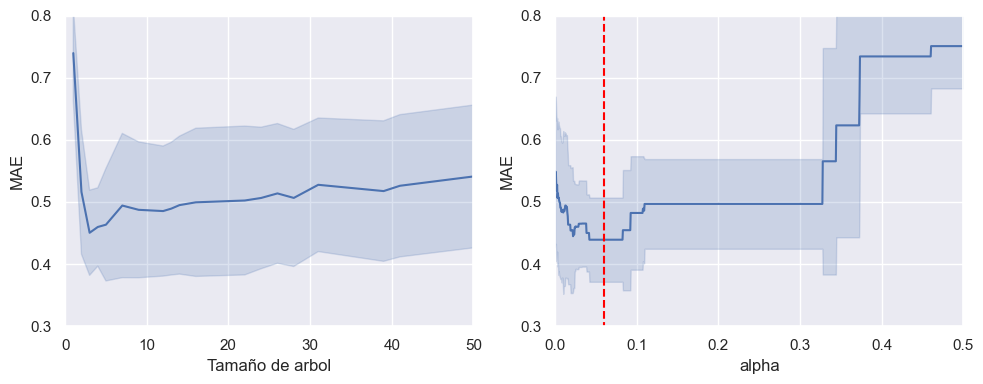

In [65]:
f, ax = plt.subplots(1,2, figsize=(10, 4))
sns.lineplot(data=df_results, x="on_leaf", y="value", errorbar="sd", ax=ax[0])
sns.lineplot(data=df_results, x="alpha", y="value", errorbar="sd", ax=ax[1])
ax[1].plot([0.06, 0.06], [-10, 10], color="red", linestyle="--")

ax[0].set_xlabel("Tamaño de arbol")
ax[0].set_ylabel("MAE")
ax[0].set_xlim([0, 50])
ax[1].set_xlim([0, 0.5])
ax[0].set_ylim([0.3, 0.8])
ax[1].set_ylim([0.3, 0.8])
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("MAE")
plt.tight_layout()

#La izquierda es la cantidad de hojas y el error cuadrático meido, que va disminuyendo, luego se equilibra porque se hace estable
#El error, a medida que se achiva el árbol disminuye el error, hay un punto de equilibro entre la cantidad de hojas y el error.
#Hay un alpha donde tenemos un menor error.
#El análisis de la validación cruzada es el alpha con menor error. El de la marca roja, tomamos el de 0.06 el centro de la meseta.
#El sombreado celeste es la varianza que da parecido porque el data set es chico.

Elijamos el valor de alpha de 0.06: 

In [66]:
# Creamos el arbol. Pero el alpha lo cambiamos. Hoja de hasta 1 muestra
regression = DecisionTreeRegressor(criterion='squared_error', splitter='best', 
                                   max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                   random_state=42, ccp_alpha=0.06)
# Y entrenamos 
regression.fit(X_train, y_train)

# Hacemos las predicciones
y_pred_train = regression.predict(X_train)
y_pred = regression.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae = mean_absolute_error(y_test, y_pred)

print(f"El error de entreamiento fue: {mae_train}")
print(f"El error de testeo fue: {mae}")

#El error es alto, pero hemos dejado de hacer overfitting porque con los datos de entrenamiento comete error

El error de entreamiento fue: 0.41363466446347563
El error de testeo fue: 0.499767325158296


El modelo no mejoro, pero es mucho mas general y tiene pocas ramas. Si lo vemos, nos damos cuenta que es el modelo que arrancamos la clase.

In [67]:
export_graphviz(regression, out_file = "arbol_regresion_alpha.dot",
                feature_names=["Hits", "PutOuts", "RBI", "Runs", "Walks", "Years"],
                rounded=True,
                filled=True)
#Nos queda el árbol mostrado en la clase. Es el mejor que se puede obtener sin oberfitting


---
## Arboles de clasificación

Para practicar el modelo de arbol de clasificación, vamos a usar el dataset [**Heart**](https://archive.ics.uci.edu/dataset/45/heart+disease), el cual mediciones de 1025 pacientes, con 13 atributos de variables fisiologicas. Además contamos con una columna de valores binarios llamada **target** que nos indica si el paciente tiene una enfermedad coronaria o no.

In [68]:
# Cargamos el dataset
df_heart = pd.read_csv("./Heart.csv")
#Vamos a cargar otro data set

In [69]:
df_heart.info()
#No hay datos perididos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [70]:
df_heart.describe()
#Son todas variables 

age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.000000     0.000000     0.000000   120.000000   211.00000   
50%      56.000000     1.000000     1.000000   130.000000   240.00000   
75%      61.000000     1.000000     2.000000   140.000000   275.00000   
max      77.000000     1.000000     3.000000   200.000000   564.00000   

               fbs      restecg      thalach        exang      oldpeak  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean      0.149268     0.529756   149.114146     0.336585     1.071512   
std       0.356527     0.527878    23.005724     0.472772     1.175053   
min       0.000000     0.000000    71.000000     0.000000     0.000000   
25%       0.000000     0.000000   132.000000     0.000000     0.000000   
50%       0.000000     1.000000   152.000000     0.000000     0.800000   
75%       0.000000     1.000000   166.000000     1.000000     1.800000   
max       1.000000     2.000000   202.000000     1.000000     6.200000   

             slope           ca         thal       target  
count  1025.000000  1025.000000  1025.000000  1025.000000  
mean      1.385366     0.754146     2.323902     0.513171  
std       0.617755     1.030798     0.620660     0.500070  
min       0.000000     0.000000     0.000000     0.000000  
25%       1.000000     0.000000     2.000000     0.000000  
50%       1.000000     0.000000     2.000000     1.000000  
75%       2.000000     1.000000     3.000000     1.000000  
max       2.000000     4.000000     3.000000     1.000000

Las clases están bastante balanceadas, voy a usar F1-Score como metrica de evaluación

In [26]:
df_heart.target.value_counts()
#Vemos el balanceo del target. Están bastante balanceadas


1    526
0    499
Name: target, dtype: int64

---
Trabajemos en el modelo

Para este caso vamos a usar todos los atributos. Una ventaja del modelo de arbol es que no nos afecta el tipo de variable, podes usar variables categoricas sin problemas.

In [71]:
X = df_heart.iloc[:, :-1].values
y = df_heart.iloc[:, -1].values

#Trabajamos con el modelo, tomamos las x e y

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Ahora vamos a aplicar el modelo, primero llamamos al modelo de [arbol de clasificación](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [73]:
from sklearn.tree import DecisionTreeClassifier 

# Creamos el arbol, como es categórica le ponemos el criterio de entropía y sin alpha
classification = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                        random_state=42)
# Y entrenamos
classification.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Podemos ver a nuestro arbol para entender que hizo usando export_graphviz

In [74]:
export_graphviz(classification, out_file = "arbol_clasificacion.dot",
                feature_names=df_heart.columns[:-1],
                class_names=["No tiene enfermedad cardiaca", "Tiene enfermedad cardiaca"],
                rounded=True,
                filled=True)
#Exportamos para verlo gráficamente.
#Son diversas la cantida de muestras por hojas. Pero más fácil porque la salida es binaria

Midamos como este modelo performa usando el F1-score:

In [75]:
from sklearn.metrics import f1_score

y_pred_train = classification.predict(X_train)
y_pred = classification.predict(X_test)

f1_train = f1_score(y_train, y_pred_train)
f1 = f1_score(y_test, y_pred)

print(f"F1-score de entreamiento fue: {f1_train}")
print(f"F1-score de testeo fue: {f1}")
#Vemos que el FSCORE es 1 y necesitamos que sea lo más alto posible,
#El de testeo es casi 1, tenemos sobreajuste. 
#Pero como es alto testeo está muy bien

F1-score de entreamiento fue: 1.0
F1-score de testeo fue: 0.9898305084745762


El modelo predijo muy bien el set de testeo. Podemos ver otra forma de aplicar cross-validation pero en este caso jugando con la maxima profundidad que puede tener el modelo:

In [76]:
# Hagamos Cross-validation para varios valores de profundidad del arbol y vamos con funciona con este
scores_list = []
depth_array = np.arange(1, 30)
leaf_array = np.zeros_like(depth_array)
for index, depth in enumerate(depth_array):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    scores_list.append(np.abs(cross_val_score(clf, X_train, y_train, cv=10, scoring='f1')))
    clf.fit(X_train, y_train)

scores_array = np.array(scores_list)
del scores_list

df_results = pd.DataFrame({"depth": depth_array,
                           "f11": scores_array[:, 0],
                           "f12": scores_array[:, 1],
                           "f13": scores_array[:, 2],
                           "f14": scores_array[:, 3],
                           "f15": scores_array[:, 4]})

df_results = pd.melt(df_results, id_vars=['depth'], value_vars=["f11", "f12", "f13", "f14", "f15"])

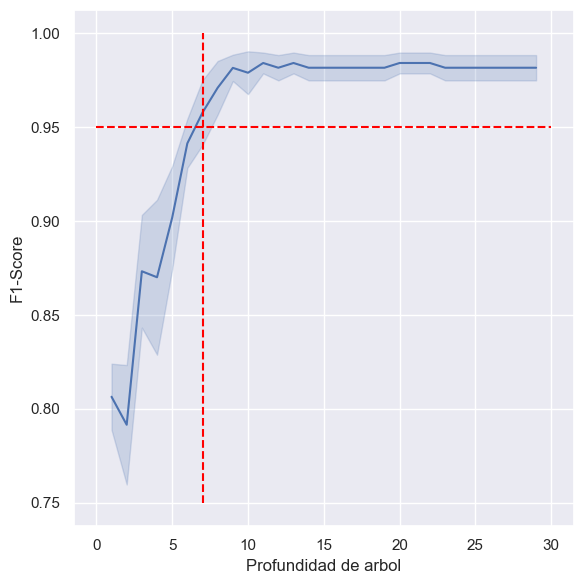

In [77]:
f, ax = plt.subplots(1,1, figsize=(6, 6))
sns.lineplot(data=df_results, x="depth", y="value", errorbar="sd", ax=ax)
ax.plot([7, 7], [0.75, 1], color="red", linestyle="--")
ax.plot([0, 30], [0.95, 0.95], color="red", linestyle="--")

ax.set_xlabel("Profundidad de arbol")
ax.set_ylabel("F1-Score")
plt.tight_layout()
#Hacemos el mimso gráfico de hace rato. Veamos por más que lo hagamos más profundo el score del modelo 
#no sigue aumentando. No tiene sentido hacerlo más profundo.
#el el valor ojo me dice que no vale más la pena aumentar la profundidad.


Vemos que en poca profundidad el arbol empieza a performar muy bien, pero de base con solo 1 profunidad ya nos da muy buenos resultados. Para este caso, supongamos que se puso como criterio a 0.95, entonces busquemos el arbol mas chico que tenga ese valor de f1-score que es de profundidad 7.

In [78]:
# Creamos el arbol
classification = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)
# Y entrenamos
classification.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)

In [79]:
y_pred = classification.predict(X_test)

f1 = f1_score(y_test, y_pred)

print(f"F1-score de testeo fue: {f1}")
#Bajó de 0.98 a 0.94

F1-score de testeo fue: 0.9438943894389439


In [81]:
export_graphviz(classification, out_file = "arbol_clasificacion_level7.dot",
                feature_names=df_heart.columns[:-1],
                class_names=["No tiene enfermedad cardiaca", "Tiene enfermedad cardiaca"],
                rounded=True,
                filled=True)

Veamos un modelo dos dimensional para ver como es la región de clasificación de un modelo

In [82]:
X = df_heart.loc[:, ["age", "trestbps"]].values
y = df_heart.iloc[:, -1].values

# Creamos el arbol
classification = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Y entrenamos
classification.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=42)

/var/folders/50/q05bl7gj7jxb0qq6rb67fp4m0000gn/T/ipykernel_2160/3500360777.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


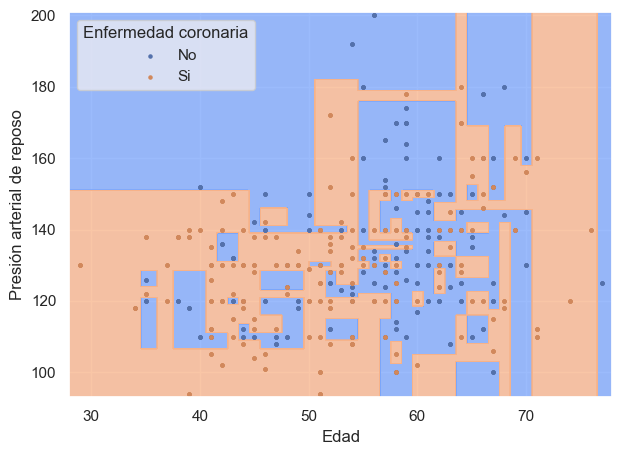

In [83]:
from matplotlib.colors import ListedColormap
#Hacemos esto para pintar la gráfica y marcar los puntos
# Crear la malla de puntos para el gráfico
X_set, y_set = X, y
X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.1),
    np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.1)
)

X_cont = np.array([X1.ravel(), X2.ravel()]).T

# Crear el gráfico de contorno
plt.figure(figsize=(7, 5))
plt.contourf(
    X1, X2, classification.predict(X_cont).reshape(X1.shape),
    alpha=0.75, cmap=ListedColormap(('#7aa5fb', '#f8b389'))
)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Graficar los puntos de entrenamiento
lab = ["No", "Si"]
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(
        X_set[y_set == j, 0], X_set[y_set == j, 1],
        c=ListedColormap(('#5471ab', '#d1885c'))(i), label=lab[i],
        s=5
    )

plt.xlabel('Edad') 
plt.ylabel('Presión arterial de reposo') 
plt.legend(title="Enfermedad coronaria")

plt.show()
#Se pueden ver como se generan las regiones para ambas clases

---
## Bosques aleatorios

Por ultimo vamos a utilizar un ejemplo de bosque aleatorio. Con estos bosques podemos usar casos de [clasificación](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier), como asi tambien de [regresión](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Ahora vamos a hacer un ejemplo de regresión, pero el procedimiento de clasificación es similar.

In [39]:
# Cargamos el dataset
df_hitters = pd.read_csv("./Hitters.csv")

# Como los datos de salario no están completos, descartamos a aquellos jugadores que no tienen ese dato.
df_hitters.dropna(subset="Salary", inplace=True)

# Aplico feature engineering, modificando el target por el logaritmo
df_hitters["Salary_log"] = np.log(df_hitters["Salary"])

df_hitters.drop(columns="Salary", inplace=True)

In [40]:
X = df_hitters.iloc[:, :-1].values
# Y como variable a predecir a Salary_log
y = df_hitters.iloc[:, -1].values

# Para este ejemplo, solo voy a usar Years, RBI, PutOuts, Hits, Walks, Run como atributos. 
X = df_hitters.loc[:, ["Hits", "PutOuts", "RBI", "Runs", "Walks", "Years"]].values
# Y como variable a predecir a Salary_log
y = df_hitters.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Para este ejemplo, no vamos a tocar mucho los parametros, se usaran 100 arboles aleatorios usando bagging y seccionando a los atributos de entrada

In [41]:
# importamos RandomForestRegressor de los metodos de ensamble de sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor

regression = RandomForestRegressor(random_state = 42)
regression.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [42]:
y_pred_train = regression.predict(X_train)
y_pred = regression.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae = mean_absolute_error(y_test, y_pred)

print(f"El error de entreamiento fue: {mae_train}")
print(f"El error de testeo fue: {mae}")

El error de entreamiento fue: 0.14242278057017446
El error de testeo fue: 0.34656304520733877


Aqui vemos como mejoramos el modelo al trabajar con un bosque en vez de un solo arbol.